In [1]:
import os
import vector
import mplhep
import numpy as np
import pandas as pd
import awkward as ak
import boost_histogram as bh
import matplotlib.pyplot as plt
import matplotlib as mpl
    
import mplhep
mplhep.style.use("CMS")

In [2]:
# data_dir = '/eos/user/l/ltani/ML-tau-data'
# zh_path = os.path.join(data_dir, 'zh.parquet')
# z_path = os.path.join(data_dir, 'z.parquet')
# qq_path = os.path.join(data_dir, 'qq.parquet')

In [3]:
# Temporary data directory
data_dir = '/scratch/persistent/joosep/ml-tau/20240402_full_stats_merged/'
zh_path = os.path.join(data_dir, 'zh_train.parquet')
z_path = os.path.join(data_dir, 'z_train.parquet')
qq_path = os.path.join(data_dir, 'qq_train.parquet')

In [4]:
# Read parquet files
zh_data = ak.from_parquet(zh_path)
z_data = ak.from_parquet(z_path)
qq_data = ak.from_parquet(qq_path)

In [5]:
# Access properties associated for each jet. Same for each dataset
zh_data.fields

['reco_cand_p4s',
 'reco_cand_charge',
 'reco_cand_pdg',
 'reco_jet_p4s',
 'reco_cand_dz',
 'reco_cand_d3',
 'reco_cand_dz_err',
 'reco_cand_d3_err',
 'reco_cand_d0',
 'reco_cand_z0',
 'reco_cand_d0_err',
 'reco_cand_z0_err',
 'gen_jet_p4s',
 'gen_jet_tau_decaymode',
 'gen_jet_tau_p4s',
 'gen_jet_full_tau_p4s']

In [26]:
print(len(z_data['gen_jet_tau_decaymode']))
print(len(zh_data['gen_jet_tau_decaymode']))
print(len(qq_data['gen_jet_tau_decaymode']))

366024
424584
2818761


## Description of variables

|  Name |  Description |
|---|---|
| reco_cand_p4s | 4-momenta per reco cand in the reco jet. |
| reco_cand_charge | Charge per cand in the jet.|
| reco_cand_pdg | PDGid per cand in the jet.|
| reco_jet_p4s | RecoJet 4-momenta. |
| reco_cand_dz | Longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dz_err | Uncertainty of the longitudinal impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy | Transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| reco_cand_dxy_err | Uncertainty of the transverse impact parameter per cand in the jet. For future steps. Fill value used for neutral cands as no track parameters can be calculated. |
| gen_jet_p4s | GenJet 4-momenta. Matched with RecoJet within a cone of radius dR < 0.4.|
| gen_jet_tau_decaymode | Decay mode of the associated genTau. Jets that have associated leptonically decaying taus are removed, so there are no DM=16 jets. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_tau_p4s | Visible 4-momenta of the genTau. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. |
| gen_jet_full_tau_p4s | Full 4-momenta (with neutrino) of the genTau matched to the genJet and recoJet. If no GenTau can be matched to GenJet within dR<0.4, fill value is used. (For debugging purposes)|

In [6]:
# Create 4-vectors from the information in the .parquet file data and access information such as energy or pT:

def to_p4(p4_obj):
    return vector.awk(
        ak.zip(
            {
                "mass": p4_obj.tau,
                "x": p4_obj.x,
                "y": p4_obj.y,
                "z": p4_obj.z,
            }
        )
    )

def to_bh(data, bins, cumulative=False):
    h1 = bh.Histogram(bh.axis.Variable(bins))
    h1.fill(data)
    if cumulative:
        h1[:] = np.sum(h1.values()) - np.cumsum(h1)
    return h1

# ZH
zh_gen_tau_p4s = to_p4(zh_data.gen_jet_tau_p4s)
zh_reco_cand_p4s = to_p4(zh_data.reco_cand_p4s)
zh_reco_jet_p4s = to_p4(zh_data.reco_jet_p4s)
zh_gen_tau_pt = zh_gen_tau_p4s.pt

# Z
z_gen_tau_p4s = to_p4(z_data.gen_jet_tau_p4s)
z_reco_cand_p4s = to_p4(z_data.reco_cand_p4s)
z_reco_jet_p4s = to_p4(z_data.reco_jet_p4s)
z_gen_tau_pt = z_gen_tau_p4s.pt

### $\Delta \eta$ and $\Delta \phi$

In [7]:
# Δη = η_jet − η_cands same for ΔΦ

def deltaphi(phi1, phi2):
    diff = phi1 - phi2
    return np.arctan2(np.sin(diff), np.cos(diff))

# Z
z_delta_phi = deltaphi(z_reco_jet_p4s.phi, z_reco_cand_p4s.phi)
z_delta_eta = z_reco_jet_p4s.eta - z_reco_cand_p4s.eta

# ZH
zh_delta_phi = deltaphi(zh_reco_jet_p4s.phi, zh_reco_cand_p4s.phi)
zh_delta_eta = zh_reco_jet_p4s.eta - zh_reco_cand_p4s.eta

## Number of particles per jet

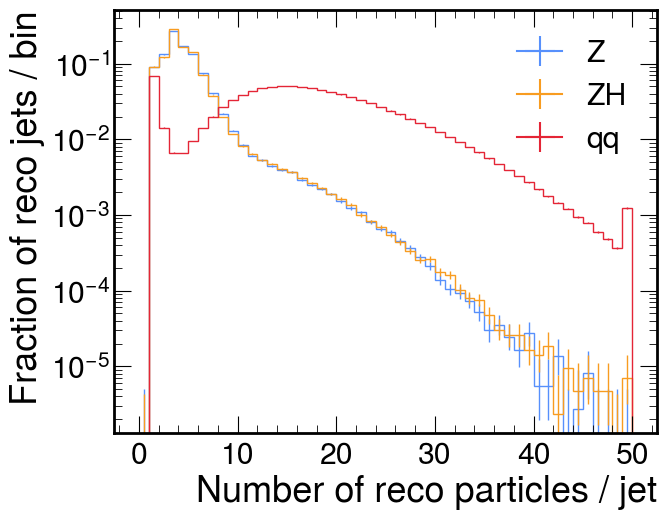

In [8]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,50,51)

# Z plot
mplhep.histplot(to_bh(ak.num(z_data["reco_cand_p4s"]), bins=bins), 
                histtype="step", 
                lw=1, 
                flow="sum", 
                label="Z", 
                density=True)
# ZH plot
mplhep.histplot(to_bh(ak.num(zh_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)
# qq plot
mplhep.histplot(to_bh(ak.num(qq_data["reco_cand_p4s"]), bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best")
plt.yscale("log")

plt.xlabel("Number of reco particles / jet")
plt.ylabel("Fraction of reco jets / bin")

#plt.tight_layout()

plt.savefig("number_reco_particles.pdf", bbox_inches='tight')

## Reconstructed jet $p_T$

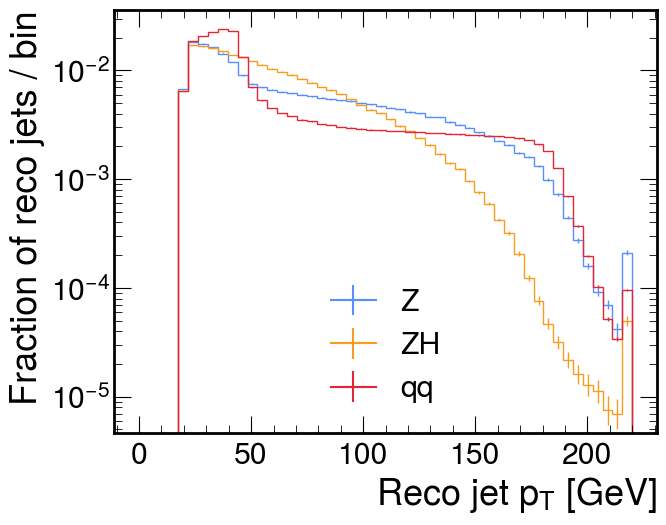

In [9]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="ZH",
                density=True)
# qq plot
mplhep.histplot(to_bh(to_p4(qq_data["reco_jet_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1,
                flow="sum",
                label="qq",
                density=True)

plt.legend(loc="best")
plt.yscale("log")

plt.xlabel("Reco jet $p_T$ [GeV]")
plt.ylabel("Fraction of reco jets / bin");

plt.savefig("reco_jet_pt.pdf", bbox_inches='tight')

### Generated jet $p_T$

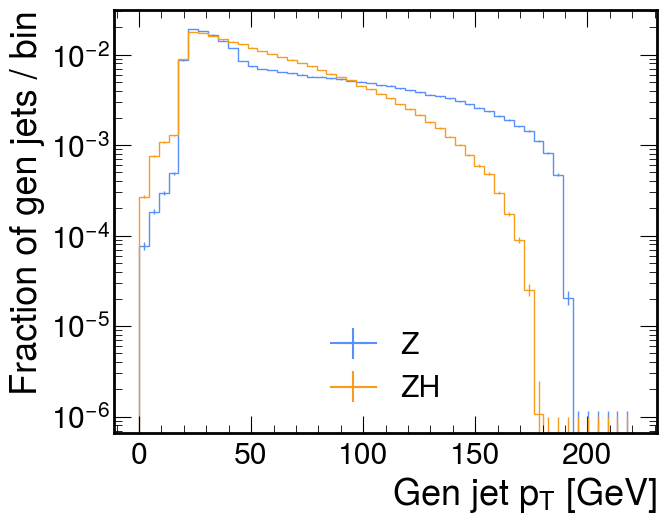

In [10]:
plt.figure(figsize=(7,5.5))
bins = np.linspace(0,220,51)

# Z plot
mplhep.histplot(to_bh(to_p4(z_data["gen_jet_tau_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="Z",
                density=True)
# ZH plot
mplhep.histplot(to_bh(to_p4(zh_data["gen_jet_tau_p4s"]).pt, bins=bins),
                histtype="step",
                lw=1, flow="sum",
                label="ZH",
                density=True)

plt.legend(loc="best")
plt.yscale("log")
plt.xlabel("Gen jet $p_T$ [GeV]")
plt.ylabel("Fraction of gen jets / bin");

plt.savefig("gen_jet_pt.pdf", bbox_inches='tight')

### Generated and reconstructed jet $p_T$ comparison
Should be around 1

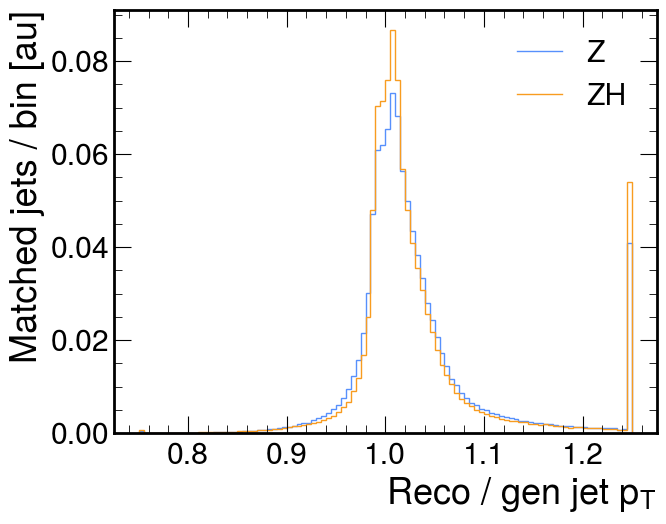

In [11]:
bins = np.linspace(0.75,1.25,101)
plt.figure(figsize=(7,5.5))

# Normalize pT
# Z
z_pt = (to_bh(to_p4(z_data["reco_jet_p4s"]).pt / to_p4(z_data["gen_jet_tau_p4s"]).pt, bins=bins) /
        len(to_p4(z_data["reco_jet_p4s"]).pt))
# ZH
zh_pt = (to_bh(to_p4(zh_data["reco_jet_p4s"]).pt / to_p4(zh_data["gen_jet_tau_p4s"]).pt, bins=bins) /
         len(to_p4(zh_data["reco_jet_p4s"]).pt))

# Z plot
mplhep.histplot(z_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="Z",
    density=False)

# ZH plot
mplhep.histplot(zh_pt,
    histtype="step",
    lw=1,
    flow="sum",
    label="ZH",
    density=False)

plt.legend(loc="best")
#plt.yscale("log")
plt.xlabel("Reco / gen jet $p_T$")
plt.ylabel("Matched jets / bin [au]");

plt.savefig("reco_gen_jet_pt.pdf", bbox_inches='tight')

## Decay mode Mapping

<table>
<tr>
<th>One Prong</th>
<th>Two Prong</th>
<th>Three Prong</th>
<th>Other</th>
</tr>
<tr>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 0  | OneProng0PiZero   | $\text{h}^\pm$       |
| 1  | OneProng1PiZero   | $\text{h}^\pm + \pi^0$|
| 2  | OneProng2PiZero   | $\text{h}^\pm + 2\pi^0$|
| 3  | OneProng3PiZero   | $\text{h}^\pm + 3\pi^0$|
| 4  | OneProngNPiZero   | $\text{h}^\pm + N\pi^0$|

</td>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 5  | TwoProng0PiZero   | $\text{2h}$          |
| 6  | TwoProng1PiZero   | $\text{2h} + \pi^0$  |
| 7  | TwoProng2PiZero   | $\text{2h} + 2\pi^0$ |
| 8  | TwoProng3PiZero   | $\text{2h} + 3\pi^0$ |
| 9  | TwoProngNPiZero   | $\text{2h} + N\pi^0$ |

</td>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 10 | ThreeProng0PiZero | $\text{3h}^\pm$      |
| 11 | ThreeProng1PiZero | $\text{3h}^\pm + \pi^0$|
| 12 | ThreeProng2PiZero | $\text{3h}^\pm + 2\pi^0$|
| 13 | ThreeProng3PiZero | $\text{3h}^\pm + 3\pi^0$|
| 14 | ThreeProngNPiZero | $\text{3h}^\pm + N\pi^0$|

</td>
<td>

| #  | Name              | Channel              |
|----|-------------------|----------------------|
| 15 | RareDecayMode     | Other                |

</td>
</tr>
</table>


In [12]:
def DM_percentages(data):
    """
    Calculate the percentages of decay modes in the given data.
    """
    uniques, counts = np.unique(data, return_counts=True)
    total_count = sum(counts)
    percentages = np.round((counts / total_count) * 100, 2)
    return dict(zip(uniques, percentages))

z_data_percentages = DM_percentages(z_data["gen_jet_tau_decaymode"])
zh_data_percentages = DM_percentages(zh_data["gen_jet_tau_decaymode"])

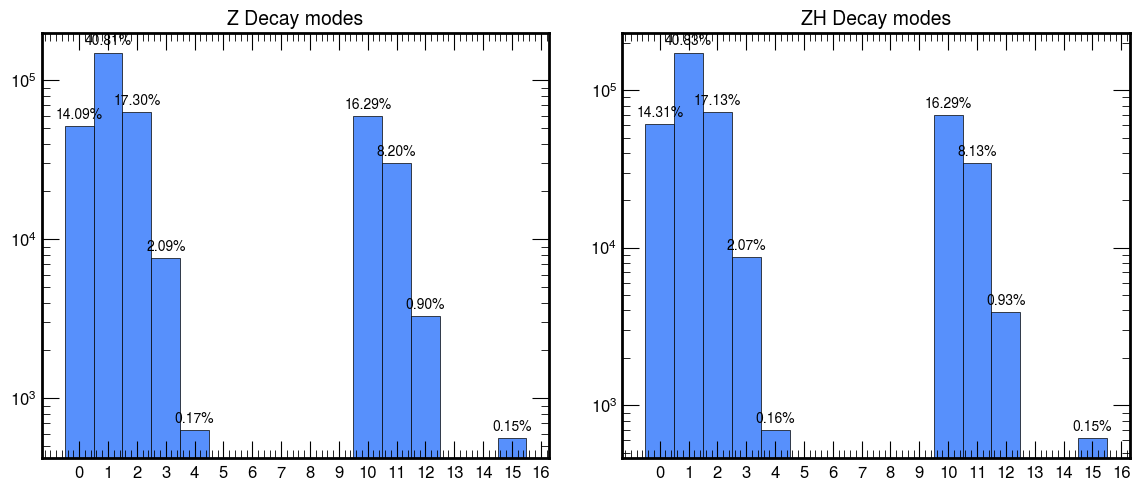

In [13]:
def annotate_bars(ax, percentages, total_count):
    for bar in ax.patches:
        height = bar.get_height()
        decay_mode = int(bar.get_x() + bar.get_width() / 2)
        percentage = percentages.get(decay_mode, 0)
        if height > 0:
            ax.annotate(f'{percentage:.2f}%', 
                        xy=(bar.get_x() + bar.get_width() / 2, height), 
                        xytext=(0, 3), 
                        textcoords="offset points", 
                        ha='center', va='bottom', fontsize=10)

# Two subplots
fig, axs = plt.subplots(1, 2, figsize=(12,5.5))
dms = np.arange(17)

# Z hist
axs[0].set_title("Z Decay modes", fontsize=14)
counts_z, _, bars_z = axs[0].hist(
    z_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[0].set_yscale('log')
axs[0].set_xticks(dms + 0.5, dms)
axs[0].tick_params(axis='x', labelsize=12)
axs[0].tick_params(axis='y', labelsize=12)

# Annotate bars for z_data
annotate_bars(axs[0], z_data_percentages, total_count=len(z_data["gen_jet_tau_decaymode"]))

# ZH hist
axs[1].set_title("ZH Decay modes", fontsize=14)
counts_zh, _, bars_zh = axs[1].hist(
    zh_data["gen_jet_tau_decaymode"], bins=dms,
    width=1,
    edgecolor='black',
    linewidth=0.5
)
axs[1].set_yscale('log')
axs[1].set_xticks(dms + 0.5, dms)
axs[1].tick_params(axis='x', labelsize=12)
axs[1].tick_params(axis='y', labelsize=12)

# Annotate bars for zh_data
annotate_bars(axs[1], zh_data_percentages, total_count=len(zh_data["gen_jet_tau_decaymode"]))

plt.tight_layout()
plt.show()

## Decay mode remapping
Physically meaningful DMs are 0, 1, 2, 3, 4, 10, 11, 12, 15.

Since some DMs have a very small sample we classify them under similar ones like to DM3, 4 to DM2 and DM11, 12, 13, 14 to DM10.

In [14]:
# Initial mapping
dm_mapping = {
        0: 'OneProng0PiZero',
        1: 'OneProng1PiZero',
        2: 'OneProng2PiZero',
        3: 'OneProng3PiZero',
        4: 'OneProngNPiZero',
        5: 'TwoProng0PiZero',
        6: 'TwoProng1PiZero',
        7: 'TwoProng2PiZero',
        8: 'TwoProng3PiZero',
        9: 'TwoProngNPiZero',
        10: 'ThreeProng0PiZero',
        11: 'ThreeProng1PiZero',
        12: 'ThreeProng2PiZero',
        13: 'ThreeProng3PiZero',
        14: 'ThreeProngNPiZero',
        15: 'RareDecayMode'
    }

In [15]:
# Remapped dictionary with meaningful DMs
remap_d = {0: '$h^\pm$', # DM0
           1: '$h^\pm \pi^0$', # DM1
           2: '$h^\pm \geq 2\pi^0$', # DM2, DM3, DM4
           3: '$h^\pm h^\mp h^\pm$', # DM10
           4: '$h^\pm h^\mp h^\pm \geq 1\pi^0$', # DM11, DM12, DM13, DM14
           5: 'Other'} # DM15 and others 5-9 

# Hard coded remapping function
def remap(dm_array):
    dm_array = ak.to_numpy(dm_array)
    new_array = np.ones(len(dm_array)) * -1

    # Main decay modes 
    new_array[dm_array == 0] = 0 # DM0
    new_array[dm_array == 1] = 1 # DM1
    
    new_array[dm_array == 2] = 2 # DM2
    new_array[dm_array == 3] = 2
    new_array[dm_array == 4] = 2
    
    new_array[dm_array == 10] = 3 # DM3
    
    new_array[dm_array == 11] = 4 # DM4
    new_array[dm_array == 12] = 4
    new_array[dm_array == 13] = 4
    new_array[dm_array == 14] = 4
    
    new_array[dm_array == 15] = 5 # DM5
    
    new_array[dm_array == 5] = 5
    new_array[dm_array == 6] = 5
    new_array[dm_array == 7] = 5
    new_array[dm_array == 8] = 5
    new_array[dm_array == 9] = 5

    # The action of reassuring
    if np.any(new_array == -1):
        print("Array contains -1")

    # Decay mode and it's coutns
    dm, N = np.unique(new_array, return_counts = True)
    
    return new_array, dm, N

z_remap = remap(z_data['gen_jet_tau_decaymode'])
zh_remap = remap(zh_data['gen_jet_tau_decaymode'])

## Probability cross check with PDG

In [16]:
class PDG_live:
    def __init__(self, value, error):
        self.value = value
        self.error = error
        
    def __repr__(self):
        return f"{self.value} ± {self.error}"

In [17]:
def cross_product(values, initial_value):
    return [round(v / initial_value, 4) for v in values]

def calculate_ratios_and_uncertainties(values, initial_value, initial_std):
    """Calculate ratios and their uncertainties"""
    ratios = cross_product([v.value for v in values], initial_value)
    uncertainties = []
    
    for i, measurement in enumerate(values):
        A = measurement.value
        sigma_A = measurement.error
        R = ratios[i]
        
        # Calculate relative uncertainty for the ratio
        relative_uncertainty = (sigma_A / A)**2 + (initial_std / initial_value)**2
        sigma_R = R * (relative_uncertainty)**0.5
        uncertainties.append(round(sigma_R, 4))
    
    return ratios, uncertainties

In [18]:
# Define initial value and its standard deviation
initial_perc = 64.79  # 100 - leptonic
initial_std = 0.06 # sqrt(0.04^2 + 0.04^2)

# Create the PDG values as instances of PDG_live
PDG_vals = {
    'Γ8': PDG_live(11.51, 0.05), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.217&home=
    'Γ13': PDG_live(25.93, 0.09), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.171&home=
    'Γ17': PDG_live(10.81, 0.09), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.19&home=
    'Γ64': PDG_live(9.8, 0.05), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.17&home=
    'Γ71': PDG_live(5.29, 0.05), # https://pdglive.lbl.gov/BranchingRatio.action?pdgid=S035.18&home=
    'Other': PDG_live(1.45, 0.15) # 1.45 = initial_perc - Γ8 - Γ13 - Γ17 - Γ64 - Γ71
}

# Convert dictionary values to list for processing
pdg_measurements = list(PDG_vals.values())

# Calculate ratios and uncertainties
PDG_ratios, PDG_uncertainties = calculate_ratios_and_uncertainties(pdg_measurements, initial_perc, initial_std)

# Z ratios
z_ratios = cross_product(z_remap[-1], sum(z_remap[-1]))

# ZH ratios
zh_ratios = cross_product(zh_remap[-1], sum(zh_remap[-1]))

print('z_ratios', z_ratios)
print('zh_ratios', zh_ratios)
print('PDG_ratios', PDG_ratios)

z_ratios [0.1409, 0.4081, 0.1956, 0.1629, 0.091, 0.0015]
zh_ratios [0.1431, 0.4083, 0.1936, 0.1629, 0.0906, 0.0015]
PDG_ratios [0.1777, 0.4002, 0.1668, 0.1513, 0.0816, 0.0224]


In [19]:
# The action of reassuring
print(sum(PDG_ratios), sum(z_ratios), sum(zh_ratios))

0.9999999999999999 0.9999999999999999 0.9999999999999999


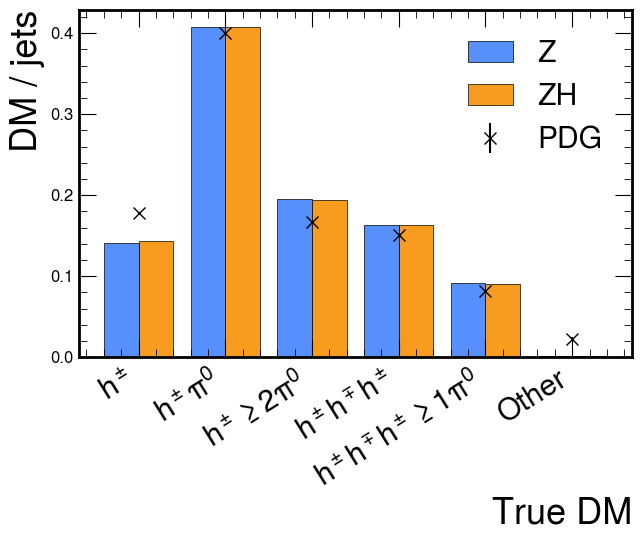

In [20]:
# Number of decay modes
ind = np.arange(len(PDG_ratios))

# Width of the bars
width = 0.4

plt.figure(figsize=(7, 6))

# Plot the bars for Z and ZH
plt.bar(ind, z_ratios, width, label='Z', edgecolor='black', linewidth=0.5)
plt.bar(ind + width, zh_ratios, width, label='ZH', edgecolor='black', linewidth=0.5)

# Plot the PDG ratios with error bars
plt.errorbar(ind + width / 2,
             PDG_ratios,
             yerr=PDG_uncertainties,
             fmt='x',
             color='k',
             markersize=8,
             label='PDG')

# Set labels and title
plt.xlabel('True DM')
plt.ylabel('DM / jets')
#plt.title('Simulation vs PDG')

# Set x-axis ticks and labels
plt.xticks(ind + width / 2, [remap_d[i] for i in remap_d], rotation=32, ha='right')
plt.yticks(fontsize=12)

# Set y-axis to logarithmic scale
#plt.yscale('log')

plt.legend(loc='best')
plt.tight_layout()

#plt.savefig('pdg_crosscheck.pdf')

plt.show()

## Z and ZH jet 2D shapes

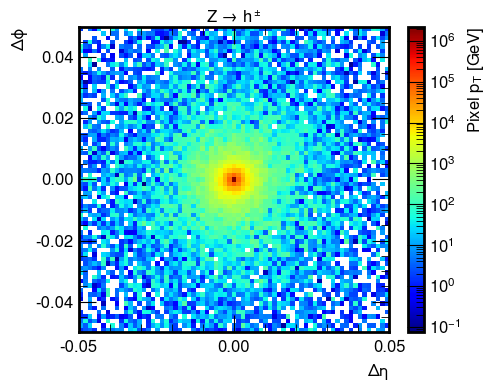

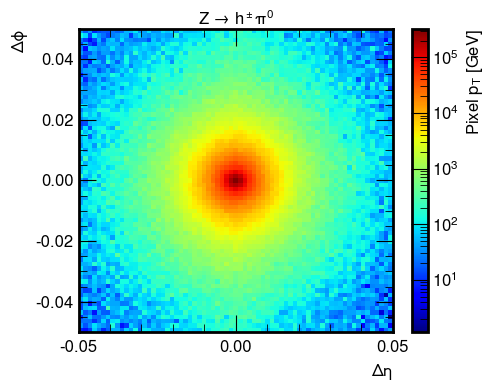

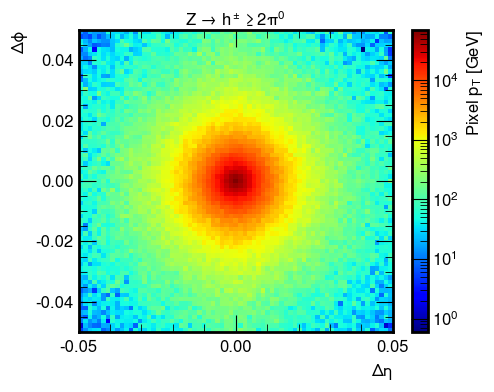

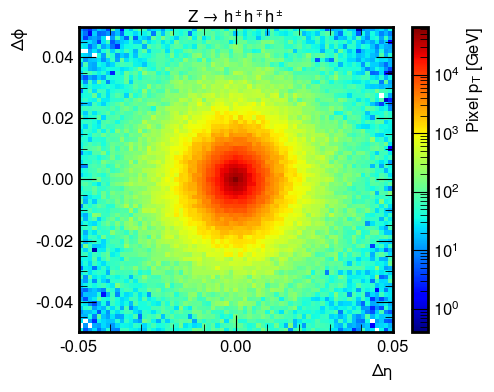

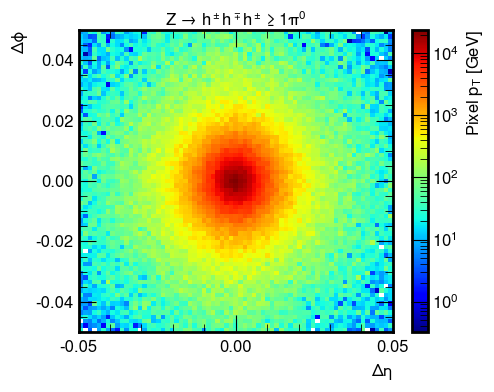

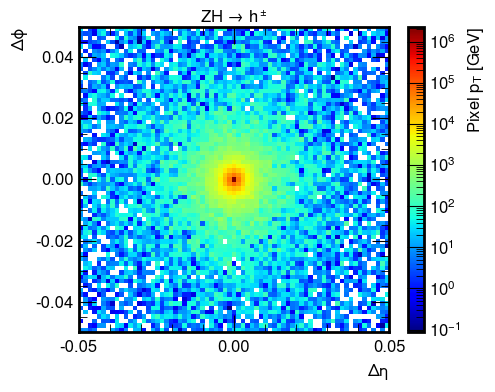

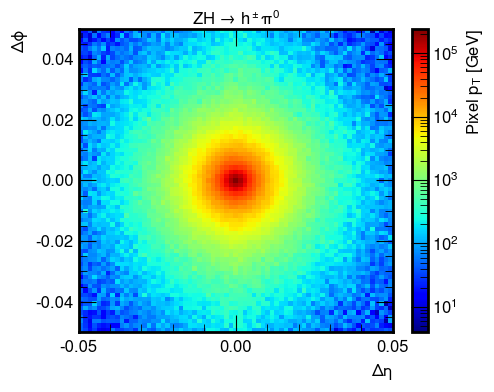

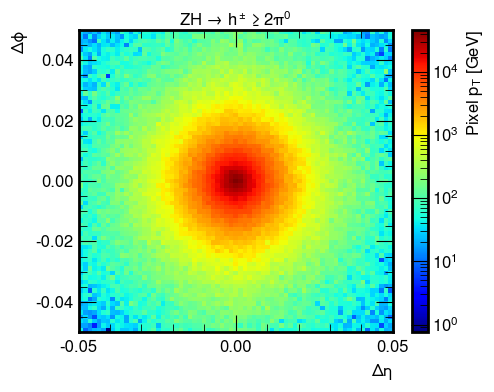

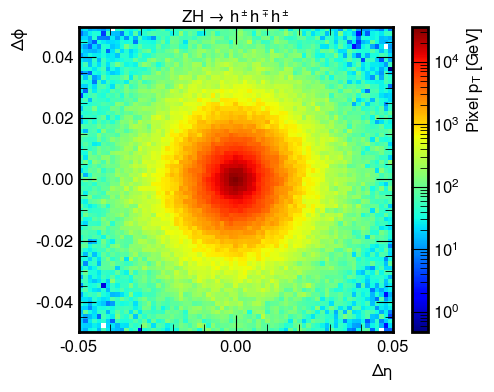

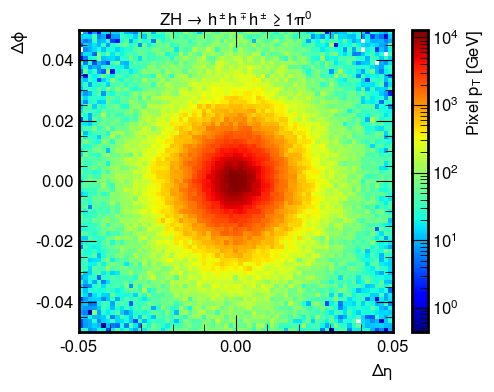

In [23]:
def plot_2d_histogram(data, mask, title, save=False, filename=None,
                      xlabel=r"$\Delta \eta$", ylabel=r"$\Delta \phi$",
                      bins=np.linspace(-0.05, 0.05, 70), cmap=mpl.cm.jet):
    
    # Flatten arrays and apply the mask
    delta_eta_flat = ak.to_numpy(ak.flatten(data['delta_eta'][mask]))
    delta_phi_flat = ak.to_numpy(ak.flatten(data['delta_phi'][mask]))
    pt_flat = ak.to_numpy(ak.flatten(data['pt'][mask]))
    
    # Create a new figure
    plt.figure(figsize=(5.5, 4.5))
    
    # Plot the 2D histogram of delta_eta and delta_phi weighted by pT
    hist2d = plt.hist2d(delta_eta_flat,
                        delta_phi_flat,
                        bins=bins,
                        weights=pt_flat,
                        norm=mpl.colors.LogNorm(), 
                        cmap=cmap)
    plt.xlabel(xlabel, fontsize=12) 
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=12, pad=3, rotation='horizontal')
    
    # Colorbar
    cbar = plt.colorbar(hist2d[3])
    cbar.set_label('Pixel $p_T$ [GeV]', fontsize=12)
    
    # Set tick parameters for x, y, and colorbar axes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.tight_layout()
    
    # Save the figure if requested
    if save and filename:
        plt.savefig(filename, format='pdf', bbox_inches='tight')

    plt.show()

def plot_histograms_for_decay_modes(data, decay_modes_of_interest, remap_d, dataset_name, save=False):
    # Loop through each decay mode 
    for idx_decaymode in decay_modes_of_interest:
        mask = (data['decay_mode'] == idx_decaymode)
        title = f'{dataset_name} → {remap_d[idx_decaymode]}'
        filename = None
        if save:
            filename = f'jet_2D_shapes_{dataset_name}_DM{idx_decaymode}.pdf'
        
        plot_2d_histogram(data, mask, title, save=save, filename=filename)

# Data dictionaries
Z_data = {
    'delta_eta': z_delta_eta,
    'delta_phi': z_delta_phi,
    'pt': z_reco_cand_p4s.pt,
    'decay_mode': z_remap[0]
}

ZH_data = {
    'delta_eta': zh_delta_eta,
    'delta_phi': zh_delta_phi,
    'pt': zh_reco_cand_p4s.pt,
    'decay_mode': zh_remap[0]
}

#decay_modes_of_interest = [0, 3]
decay_modes_of_interest = [0, 1, 2, 3, 4]

# Plot and save figures for Z data
plot_histograms_for_decay_modes(Z_data, decay_modes_of_interest, remap_d, 'Z', save=True)

# Plot and save figures for ZH data
plot_histograms_for_decay_modes(ZH_data, decay_modes_of_interest, remap_d, 'ZH', save=True)

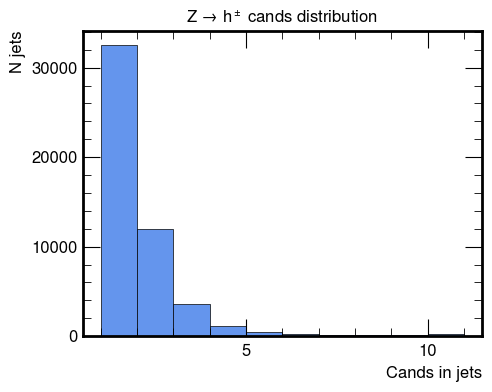

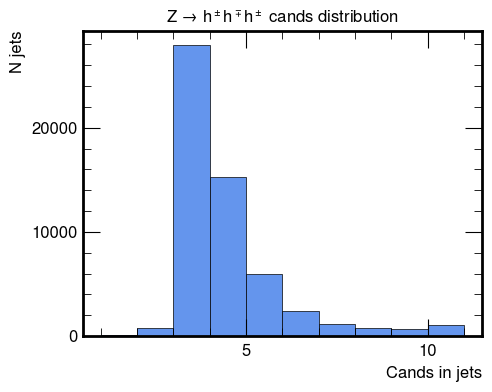

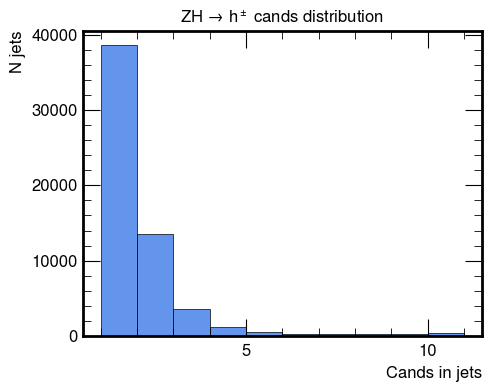

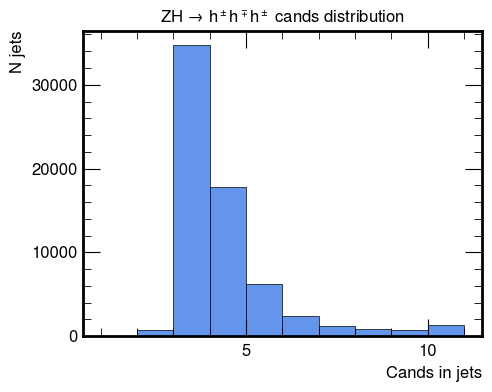

In [22]:
# Loop through each decay mode

def plot_cands_distribution(data, decay_modes_of_interest, dataset_name):
    for idx_decaymode in decay_modes_of_interest:
        mask = (data['decay_mode'] == idx_decaymode)
        cands = data["reco_cand_p4s"][mask]
        jets = data["reco_jet_p4s"][mask]
        
        # List to store particle counts per jet for the current decay mode
        cands_counts = [len(c) for c in cands]
        
        # Create a new figure for each decay mode
        plt.figure(figsize=(5.5, 4.5))
        
        # Plot the histogram of particle counts per jet
        plt.hist(cands_counts, color='cornflowerblue', bins=np.linspace(1, 11, 11),
                 edgecolor='black', linewidth=0.5)
        plt.xlabel("Cands in jets", fontsize=12) 
        plt.ylabel("N jets", fontsize=12)
        plt.title(f"{dataset_name} → {remap_d[idx_decaymode]} cands distribution", fontsize=12)
        
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
       
        plt.tight_layout()
        plt.show()

# Assuming z_data and zh_data are dictionaries containing necessary arrays
Z_data1 = {
    'reco_cand_p4s': z_reco_cand_p4s,
    'reco_jet_p4s': z_reco_jet_p4s,
    'decay_mode': z_remap[0]
}

ZH_data1 = {
    'reco_cand_p4s': zh_reco_cand_p4s,
    'reco_jet_p4s': zh_reco_jet_p4s,
    'decay_mode': zh_remap[0]
}

decay_modes_of_interest = [0, 3]

# Plot Z data
plot_cands_distribution(Z_data1, decay_modes_of_interest, 'Z')

# Plot ZH data
plot_cands_distribution(ZH_data1, decay_modes_of_interest, 'ZH')

## Any other input data visualizations